## Importing libraries and files

In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

ann_arr = load_model('IP_Arrival_time/Arrival_ANN_1')
ann_end = load_model('IP_End_time/End_ANN_2')
ann_chg = load_model('IP_Change_time/Change_ANN_3')

#Section1
ann1 = load_model('IP_Section_1_new/Section1_ANN_3')
sc1 = pickle.load(open('IP_Section_1_new/Section1_scaler_ANN_3.pkl', 'rb'))
#Section2
ann2 = load_model('IP_Section_2_new/Section2_new_ANN_5')
sc2 = pickle.load(open('IP_Section_2_new/Section2_new_scaler_ANN_5.pkl', 'rb'))
#Section3
ann3 = load_model('IP_Section_3_new/Section3_new_ANN_1')
sc3 = pickle.load(open('IP_Section_3_new/Section3_new_scaler_ANN_1.pkl', 'rb'))
#Section4
ann4 = load_model('IP_Section_4_new/Section4_new_ANN_1')
sc4 = pickle.load(open('IP_Section_4_new/Section4_new_scaler_ANN_1.pkl', 'rb'))
#Section5
ann5 = load_model('IP_Section_5_new/Section5_new_ANN_1')
sc5 = pickle.load(open('IP_Section_5_new/Section5_new_scaler_ANN_1.pkl', 'rb'))
#Section6
ann6 = load_model('IP_Section_6_new/Section6_new_ANN_1')
sc6 = pickle.load(open('IP_Section_6_new/Section6_new_scaler_ANN_1.pkl', 'rb'))

## Input details

In [90]:
charge_mass = 16.2
standoff_distance = 26.3
start_time = 55
termination_time = 110
interval = 0.01

## Pressure Profile

In [91]:
arr = np.array ([[charge_mass,standoff_distance]])

arrival_time = ann_arr.predict(arr)
end_time = ann_end.predict(arr)
change_time = ann_chg.predict(arr)
print ("end", end_time, "change", change_time)

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)

    p = np.repeat(0, len(t)).reshape(len(t),1)
    
    values = np.concatenate ((t, p), axis = 1)
    return values

def p_fluctuation(standoff_distance, d_set):
    if 1.5 <= standoff_distance <= 3:
        d_set[:,0:3] = sc1.transform(d_set[:,0:3])
        p_f = ann1.predict(d_set)
        section = 1
        
    elif 3 < standoff_distance <= 7:
        d_set[:,0:3] = sc2.transform(d_set[:,0:3])
        p_f = ann2.predict(d_set)
        section = 2
        
    elif 7 < standoff_distance <= 13:
        d_set[:,0:3] = sc3.transform(d_set[:,0:3])
        p_f = ann3.predict(d_set)
        section = 3
        
    elif 13 < standoff_distance <= 19:
        d_set[:,0:3] = sc4.transform(d_set[:,0:3])
        p_f = ann4.predict(d_set)
        section = 4
        
    elif 19 < standoff_distance <= 25:
        d_set[:,0:3] = sc5.transform(d_set[:,0:3])
        p_f = ann5.predict(d_set)
        section = 5
        
    elif 25 < standoff_distance <= 30:
        d_set[:,0:3] = sc6.transform(d_set[:,0:3])
        p_f = ann6.predict(d_set)
        section = 6
        
    else:
        print ("Out of trained range")
    return p_f, section

if termination_time < arrival_time:
    start = start_time
    end = termination_time
    values1 = stable_state(start, end, interval)
    arrival_time = 0
    end_time = 0

else:
    start = start_time
    end = arrival_time
    values1 = stable_state(start, end, interval)
    
    if termination_time < end_time:
        end_time = termination_time
        
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)

t2= np.arange(arrival_time, end_time + interval, interval)
t2 = t2.reshape(len(t2),1)

if t2[0] < change_time:
    ph2 = np.array([[0, 1]])
else:
    ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for time in t2[1:]:
    if time < change_time:
        ph2=np.vstack((ph2,positive))
    else:
        ph2=np.vstack((ph2,negative))
        
m2 = np.repeat(charge_mass, len(t2)).reshape(len(t2),1)
d2 = np.repeat(standoff_distance, len(t2)).reshape(len(t2),1)
d_set = np.concatenate ((m2, d2, t2, ph2), axis = 1)

p2, section = p_fluctuation(standoff_distance, d_set)
p2 = p2.reshape((-1, 1))
values2 = np.concatenate ((t2, p2), axis = 1)


if 'values2' in globals():
    ml_model = np.concatenate((values1, values2), axis=0)
    if 'values3' in globals():
        ml_model = np.concatenate((ml_model, values3), axis=0)
else:
    ml_model = values1
print (section)

X1 = ml_model[:,0]
y1 = ml_model[:,1]

1/1 [==============================] - 0s 48ms/step
end [[102.570366]] change [[71.20472]]


C:\Users\z5379606\AppData\Local\Temp\ipykernel_24076\3099970707.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = np.arange(start, end + interval, interval)
C:\Users\z5379606\AppData\Local\Temp\ipykernel_24076\3099970707.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2= np.arange(arrival_time, end_time + interval, interval)


127/127 [==============================] - 0s 3ms/step
6


In [92]:
file_path = f'IP_Num&ANN_Comparison/LSDYNA/{charge_mass}kg/{standoff_distance}m.xlsx'
lsdyna = pd.read_excel(file_path)
X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']
X2_original=X2_original*1000
y2_original=(y2_original/1000)-101.2

# Find the indices for the two values closest to value1 and value2
index1 = (np.abs(X2_original - start_time)).argmin()
index2 = (np.abs(X2_original - termination_time)).argmin()

# Extract the ranges from X2 and y2 based on the indices
X2 = X2_original[index1:index2+1]
y2 = y2_original[index1:index2+1]

X2 = X2.to_numpy()
y2 = y2.to_numpy()

print("Numerical length",len(y2), "ANN-based length", len(y1))

Numerical length 5502 ANN-based length 5504


In [93]:
X1=X1[:-2]
y1=y1[:-2]
print("ANN:",len(X1),"Num:",len(X2))
print("ANN:",len(y1),"Num:",len(y2))

ANN: 5502 Num: 5502
ANN: 5502 Num: 5502


In [94]:
# Numerical
max_index_num = np.argmax(y2)
min_index_num = np.argmin(y2)

zero_crossing_index = next((i for i, val in enumerate(y2[max_index_num:min_index_num], start=0) if val <= 0), None)+max_index_num

change_time_num = X2[zero_crossing_index]

#end_index_num = min(range(min_index_num, len(y2)), key=lambda j: abs(y2[j]))
#end_index_num = next((i for i, val in enumerate(y2[min_index_num:], start=0) if val > 0), None)+min_index_num
for k in range(len(y2) - 1, -1, -1):
    if y2[k] < -1:
        end_index_num = k
        break
print(end_time_num)

end_time_num = X2[end_index_num]

positive_duration_num = change_time_num - X2[max_index_num]
negative_duration_num = end_time_num - change_time_num


positive_peak_pressure_num = y2[max_index_num]
negative_peak_pressure_num = y2[min_index_num]

positive_peak_time_num = X2[max_index_num]
negative_peak_time_num = X2[min_index_num]

# ANN-based
positive_duration_ann = float(change_time - arrival_time)
negative_duration_ann = float(end_time - change_time)

max_index_ann = np.argmax(p2)
min_index_ann = np.argmin(p2)

positive_peak_pressure_ann = float(p2[max_index_ann])
negative_peak_pressure_ann = float(p2[min_index_ann])

positive_peak_time_ann = float(t2[max_index_ann])
negative_peak_time_ann = float(t2[min_index_ann])

75.393997133


C:\Users\z5379606\AppData\Local\Temp\ipykernel_24076\72778455.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  positive_duration_ann = float(change_time - arrival_time)
C:\Users\z5379606\AppData\Local\Temp\ipykernel_24076\72778455.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  negative_duration_ann = float(end_time - change_time)
C:\Users\z5379606\AppData\Local\Temp\ipykernel_24076\72778455.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  positive_pea

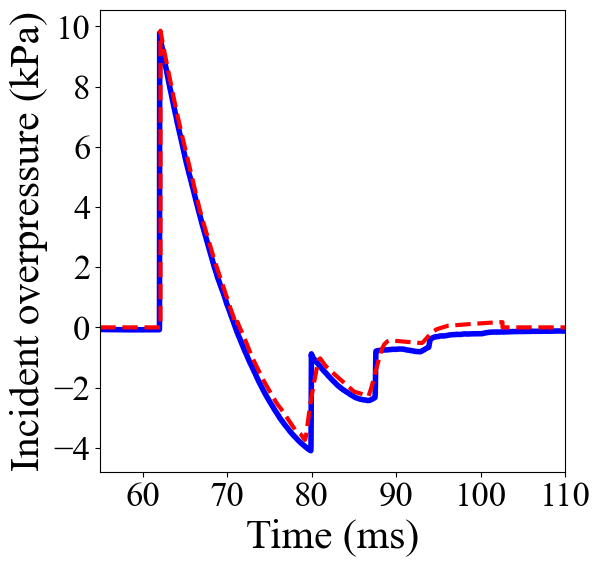

In [95]:
plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(X2, y2, color = 'blue',label = 'Numerical', linewidth=4)
plt.plot(X1, y1, linestyle = 'dashed', color = 'red', label = 'ANN framework', linewidth=3)
plt.ylabel('Incident overpressure (kPa)',fontsize = 30)
plt.xlabel('Time (ms)',fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon = False, fontsize = 20)

# Create the annotation text
#annotation_text = (f'Peak incident overpressure\n\nANN framework - {round(max(y1), 2)} kPa\n'
#                   f'Numerical - {round(max(y2), 2)} kPa')

#plt.annotate(annotation_text,xy=(0.4,0.5), xycoords='figure fraction', fontsize=18)

plt.xlim (start_time,termination_time)
plt.savefig(f'IP_Num&ANN_Comparison/Images2/Section{section}/{standoff_distance}m{charge_mass}kg.png', dpi=150, bbox_inches='tight')
plt.show()

In [96]:
# Define the lag range
lag_range = 50

# Compute full cross-correlation
cross_corr_full = np.correlate(y2, y1, mode='full')

# Find the middle index (corresponds to zero lag)
mid_idx = len(y2) - 1

# Extract the cross-correlation only within the desired lag range (-50 to 50)
cross_corr_limited = cross_corr_full[mid_idx - lag_range: mid_idx + lag_range + 1]

# Normalize the cross-correlation coefficient
norm_cross_corr = cross_corr_limited / (np.std(y2) * np.std(y1) * len(y2))

# Define the lags between -50 and 50
lags = np.arange(-lag_range, lag_range + 1)

# Find the lag that gives the maximum correlation within the restricted range
max_corr_lag = lags[np.argmax(np.abs(norm_cross_corr))]

#Plot the cross-correlation for the limited range
'''plt.plot(lags, norm_cross_corr)
plt.axvline(0, color='black', linestyle='--', label="Zero lag")
plt.axvline(max_corr_lag, color='red', linestyle='--', label=f"Max Corr Lag = {max_corr_lag}")
plt.xlabel('Lag')
plt.ylabel('Cross-correlation coefficient')
plt.title('Cross-Correlation between Numerical Model and ANN Prediction')
plt.legend()
plt.show()'''

# Check the correlation at zero lag
zero_lag_corr = norm_cross_corr[lag_range]
print(f"Cross-correlation coefficient at zero lag: {zero_lag_corr}")
print(f"Max cross-correlation coefficient lag: {max_corr_lag}")

Cross-correlation coefficient at zero lag: 0.9804443344343127
Max cross-correlation coefficient lag: -10


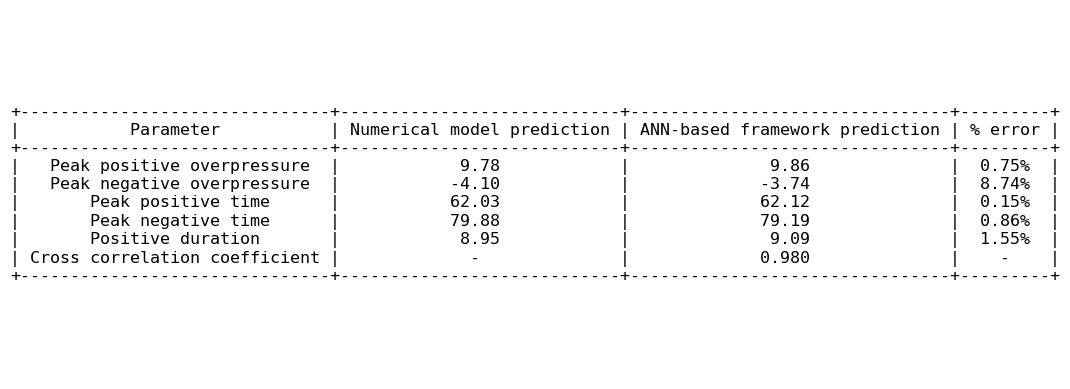

In [97]:
# Initialize PrettyTable
table = PrettyTable()

# Define columns
table.field_names = ["Parameter", "Numerical model prediction", "ANN-based framework prediction", "% error"]

# Calculate percentage errors
def per_error(true_value, predicted_value):
    return abs(predicted_value - true_value) / abs(true_value) * 100

# Add rows
table.add_row(["Peak positive overpressure", f"{positive_peak_pressure_num:.2f}", f"{positive_peak_pressure_ann:.2f}", f"{per_error(positive_peak_pressure_num, positive_peak_pressure_ann):.2f}%"])
table.add_row(["Peak negative overpressure", f"{negative_peak_pressure_num:.2f}", f"{negative_peak_pressure_ann:.2f}", f"{per_error(negative_peak_pressure_num, negative_peak_pressure_ann):.2f}%"])
table.add_row(["Peak positive time", f"{positive_peak_time_num:.2f}", f"{positive_peak_time_ann:.2f}", f"{per_error(positive_peak_time_num, positive_peak_time_ann):.2f}%"])
table.add_row(["Peak negative time", f"{negative_peak_time_num:.2f}", f"{negative_peak_time_ann:.2f}", f"{per_error(negative_peak_time_num, negative_peak_time_ann):.2f}%"])
table.add_row(["Positive duration", f"{positive_duration_num:.2f}", f"{positive_duration_ann:.2f}", f"{per_error(positive_duration_num, positive_duration_ann):.2f}%"])
#table.add_row(["Negative duration", f"{negative_duration_num:.2f}", f"{negative_duration_ann:.2f}", f"{per_error(negative_duration_num, negative_duration_ann):.2f}%"])
table.add_row(["Cross correlation coefficient", "-", f"{zero_lag_corr:.3f}", "-"])

# Convert PrettyTable to string
table_str = table.get_string()

# Set up Matplotlib figure and axes
fig, ax = plt.subplots()

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Use the table_str as the plot text
ax.text(0.5, 0.5, table_str, fontsize=12, ha="center", va="center", family="monospace")

# Save the table as an image
plt.savefig(f'IP_Num&ANN_Comparison/Images2/Section{section}/table_{standoff_distance}m{charge_mass}kg.png', bbox_inches='tight', dpi=150)

# Show the plot (optional)
plt.show()